# Imports

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('ggplot')

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

from selenium import webdriver
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

edge_options = Options()

edge_options.add_argument("--disable-images")
edge_options.add_argument("--blink-settings=imagesEnabled=false")
edge_options.add_argument("--disable-extensions")
edge_options.add_argument("--disable-gpu")
edge_options.add_argument("--no-sandbox")

edge_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36")

driver = webdriver.Edge(options=edge_options)
driver.maximize_window()

# Get Box Office

In [2]:
movie_df=pd.DataFrame()
for year in range(2020, 2026):
    url=f'https://www.boxofficemojo.com/year/world/{year}/'
    table=pd.read_html(url)[0]
    table['Year']=year
    movie_df=pd.concat([movie_df, table],ignore_index=True)

    print(year, end='\r')


2025

In [3]:
movies=movie_df['Release Group'].tolist()
movies

['Demon Slayer: Kimetsu no Yaiba - The Movie: Mugen Train',
 'The Eight Hundred',
 'Bad Boys for Life',
 'My People, My Homeland',
 'Tenet',
 'Sonic the Hedgehog',
 'Dolittle',
 'Jiang Ziya',
 'A Little Red Flower',
 'The Croods: A New Age',
 'Birds of Prey and the Fantabulous Emancipation of One Harley Quinn',
 'Shock Wave 2',
 'Wonder Woman 1984',
 'The Sacrifice',
 'The Invisible Man',
 'Onward',
 'Warm Hug',
 'Soul',
 'The Call of the Wild',
 'Caught in Time',
 'Mulan',
 'The Yin-Yang Master: Dream of Eternity',
 'Stand by Me Doraemon 2',
 'The Rescue',
 'Love You Forever',
 'Greenland',
 'Tolo Tolo',
 'Vanguard',
 'Fantasy Island',
 'Trolls World Tour',
 'The New Mutants',
 'After We Collided',
 "From Today, It's My Turn: The Movie",
 'Tanhaji: The Unsung Warrior',
 'Unhinged',
 'The End of Endless Love',
 'The War with Grandpa',
 'Peninsula',
 'Monster Hunter',
 'Underwater',
 'Bloodshot',
 'Sarileru Neekevvaru',
 'The Untold Tale of the Three Kingdoms',
 'The Confidence Man JP: 

# Get views

In [ ]:
driver.get('https://www.youtube.com/')

In [ ]:
movie_views={}

for i, movie in enumerate(movies, start=1):
    try:

        search_text=f'{movie} Trailer'
        wait = WebDriverWait(driver, 10)
        search_bar = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'input[name="search_query"]')))
        
        search_bar.clear()
        
        search_bar.send_keys(search_text)
        search_bar.send_keys(Keys.ENTER)
        time.sleep(1)
    
        views=[e.find_element(By.CSS_SELECTOR, 'span[class="inline-metadata-item style-scope ytd-video-meta-block"').text for e in driver.find_elements(By.CSS_SELECTOR, 'ytd-video-renderer') if 'trailer' in e.text.lower()]
        movie_views[movie]=views
        
    except:
        continue

    print(f'{i}/{len(movies)}', end='\r')

In [4]:
#pickle.dump(movie_views, open('movie_views.pickle','wb'))
movie_views=pickle.load( open('movie_views.pickle','rb'))

In [5]:
len(movie_views)

1175

In [6]:
movie_views_total={}
for movie, views_list in movie_views.items():
    
    total_number=0
    for view in views_list:
        view=view.split(' ')[0]
        if 'K' in view:
            number=float(view.replace('K',''))*10**3
        elif 'M' in view:
            number=float(view.replace('M',''))*10**6
        else:
            number=int(view)
            
        total_number+=number
        
    #total_number=round(total_number/10**6,4)
    movie_views_total[movie]=total_number
    

In [7]:
movie_df['Trailer Views']=movie_df['Release Group'].map(movie_views_total)

In [8]:
movie_df['Worldwide']=movie_df['Worldwide'].apply(lambda x:x.replace('$','').replace(',','').replace('-','')).apply(pd.to_numeric)
movie_df['Domestic']=movie_df['Domestic'].apply(lambda x:x.replace('$','').replace(',','').replace('-','')).apply(pd.to_numeric)
movie_df['Foreign']=movie_df['Foreign'].apply(lambda x:x.replace('$','').replace(',','').replace('-','')).apply(pd.to_numeric)

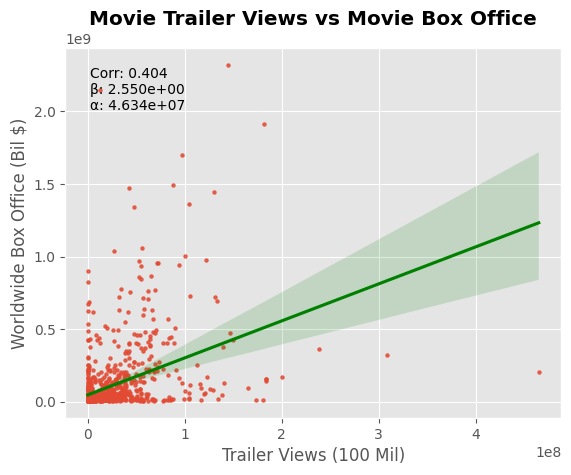

In [27]:
sns.regplot(x='Trailer Views', y='Worldwide', data=movie_df, scatter_kws={'s':5}, line_kws={'color':'green'})

xy = movie_df[['Trailer Views', 'Worldwide']].dropna()
x = xy['Trailer Views'].astype(float)
y = xy['Worldwide'].astype(float)
mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]

beta, alpha = np.polyfit(x, y, 1)
corr=round(movie_df['Worldwide'].corr(movie_df['Trailer Views']),3)


plt.text(
    0.05, 0.95,
    f'Corr: {corr}\nβ: {beta:.3e}\nα: {alpha:.3e}',
    transform=plt.gca().transAxes,
    va='top',
    ha='left'
)


plt.xlabel('Trailer Views (100 Mil)')
plt.ylabel('Worldwide Box Office (Bil $)')
plt.title('Movie Trailer Views vs Movie Box Office', fontweight='bold')

plt.show()